In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/120dog breeds-299.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/projectDataset229')

In [ ]:
import pandas as pd
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import applications
from keras.layers import Activation, Dropout, Flatten, Dense,GlobalAveragePooling2D, BatchNormalization

In [ ]:
import pathlib
from keras.preprocessing.image import ImageDataGenerator


data_dir = pathlib.Path('/content/projectDataset229/120dog breeds-299')

data_train = data_dir / 'train'

test_dir = data_dir / 'test'


labels_csv = pd.read_csv('/content/drive/MyDrive/labels.csv')
labels_csv['id'] = [str(fname) + '.jpg' for fname in labels_csv['id']]

In [ ]:
batch_size = 16
img_size = 299

In [ ]:
datagen = ImageDataGenerator(preprocessing_function = keras.applications.inception_v3.preprocess_input, validation_split=0.2)
train_generator = datagen.flow_from_dataframe(
                        dataframe = labels_csv,
                        directory = data_train,
                        subset='training',
                        x_col='id',
                        y_col='breed',
                        batch_size=batch_size,
                        shuffle=True,
                        # class_mode='sparse',
                        class_mode='categorical',
                        color_mode='rgb',
                        target_size=(img_size, img_size))

validation_generator = datagen.flow_from_dataframe(
                        dataframe = labels_csv,
                        directory = data_train,
                        subset='validation',
                        x_col='id',
                        y_col='breed',
                        batch_size=batch_size,
                        shuffle=True,
                        # class_mode='sparse',
                        class_mode='categorical',
                        color_mode='rgb',
                        target_size=(img_size, img_size))

# train_datagen = ImageDataGenerator(
#     preprocessing_function = keras.applications.inception_v3.preprocess_input, 
#     validation_split=0.2,
#     rotation_range=20, 
#     width_shift_range=0.2, 
#     height_shift_range=0.2, 
#     zoom_range=0.2, 
#     horizontal_flip=True, 
#     vertical_flip=True
# )

from keras.utils import to_categorical
# train_datagen = ImageDataGenerator(
#     preprocessing_function=keras.applications.inception_v3.preprocess_input,
#     validation_split=0.2,
#     rotation_range=5,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     zoom_range=0.1,
#     shear_range=0.05,
#     brightness_range=[0.8, 1.2],
#     horizontal_flip=True
# )


# train_generator = train_datagen.flow_from_dataframe(
#     dataframe=labels_csv,
#     directory=data_train,
#     subset='training',
#     x_col='id',
#     y_col='breed',
#     batch_size=batch_size,
#     shuffle=True,
#     # class_mode='sparse',
#     class_mode='categorical',
#     color_mode='rgb',
#     target_size=(img_size, img_size)
# )

# validation_datagen = ImageDataGenerator(
#     preprocessing_function = keras.applications.inception_v3.preprocess_input, 
#     validation_split=0.2
# )

# validation_generator = validation_datagen.flow_from_dataframe(
#     dataframe=labels_csv,
#     directory=data_train,
#     subset='validation',
#     x_col='id',
#     y_col='breed',
#     batch_size=batch_size,
#     shuffle=True,
#     # class_mode='sparse',
#     class_mode='categorical',
#     color_mode='rgb',
#     target_size=(img_size, img_size)
# )


train_labels = to_categorical(train_generator.labels)
validation_labels = to_categorical(validation_generator.labels)

Found 8178 validated image filenames belonging to 120 classes.
Found 2044 validated image filenames belonging to 120 classes.


In [ ]:
import tensorflow as tf
from tensorflow.python.keras.metrics import AUC
from sklearn.metrics import roc_curve, auc

# Define the ROC metrics
tpr = tf.keras.metrics.TruePositives(name='tp')
fpr = tf.keras.metrics.FalsePositives(name='fp')
auc_metric = AUC(name='auc')

In [ ]:
# base = applications.inception_v3.InceptionV3(include_top=False, weights='imagenet',input_shape=(224,224,3))


base = applications.inception_v3.InceptionV3(include_top=False, weights='imagenet', input_shape=(img_size, img_size, 3))


for layer in base.layers:
    layer.trainable=False

model = Sequential()
model.add(base)
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(120, activation='softmax'))
model.summary()

optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer=optimizer,
              # loss='sparse_categorical_crossentropy',
              loss='categorical_crossentropy',
              # metrics=['accuracy'])
              metrics=[tpr, fpr, auc_metric, 'accuracy', 'Precision', 'Recall'])

87910968/87910968 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 batch_normalization_94 (Bat  (None, 8, 8, 2048)       8192      
 chNormalization)                                                
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                         

In [ ]:
# history_inc = model.fit(train_generator, epochs=50, verbose = 1,
#                         validation_data=validation_generator)

from keras.callbacks import ModelCheckpoint, EarlyStopping


checkpoint_cb = ModelCheckpoint("E://dx//Level 6//Project//Topic-Ensemble Model for the Classification of Dog Breed//Codes//Saved Model//InceptionV3-299-Epoch50DataAugmentationHigh.h5", save_best_only=True)
early_stopping_cb = EarlyStopping(patience=5, restore_best_weights=True)


history_inc = model.fit(train_generator, epochs=50, verbose = 1,
                        validation_data=validation_generator,
                        callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/50
512/512 [==============================] - 68s 106ms/step - loss: 2.6970 - tp: 1003.0000 - fp: 84.0000 - auc: 0.7784 - accuracy: 0.4720 - precision: 0.9227 - recall: 0.1226 - val_loss: 0.7023 - val_tp: 1357.0000 - val_fp: 72.0000 - val_auc: 0.9274 - val_accuracy: 0.8601 - val_precision: 0.9496 - val_recall: 0.6639
Epoch 2/50
512/512 [==============================] - 51s 99ms/step - loss: 0.7971 - tp: 5134.0000 - fp: 465.0000 - auc: 0.9563 - accuracy: 0.8165 - precision: 0.9169 - recall: 0.6278 - val_loss: 0.4013 - val_tp: 1698.0000 - val_fp: 128.0000 - val_auc: 0.9709 - val_accuracy: 0.8845 - val_precision: 0.9299 - val_recall: 0.8307
Epoch 3/50
512/512 [==============================] - 49s 96ms/step - loss: 0.5202 - tp: 6344.0000 - fp: 581.0000 - auc: 0.9778 - accuracy: 0.8536 - precision: 0.9161 - recall: 0.7757 - val_loss: 0.3527 - val_tp: 1759.0000 - val_fp: 156.0000 - val_auc: 0.9822 - val_accuracy: 0.8865 - val_precision: 0.9185 - val_recall: 0.8606
Epoch 4/50
512/51

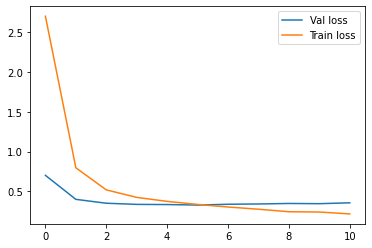

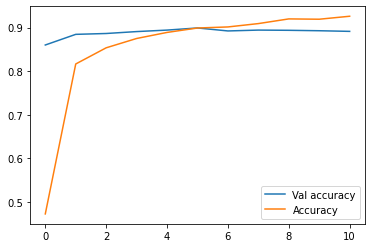

In [ ]:
plt.figure()
plt.plot(history_inc .history['val_loss'], label = 'Val loss')
plt.plot(history_inc .history['loss'], label = 'Train loss')
plt.legend()
plt.show()
plt.figure()
plt.plot(history_inc .history['val_accuracy'], label = 'Val accuracy')
plt.plot(history_inc .history['accuracy'], label = 'Accuracy')
plt.legend()
plt.show()

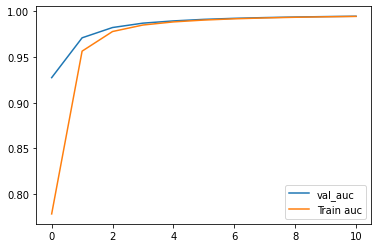

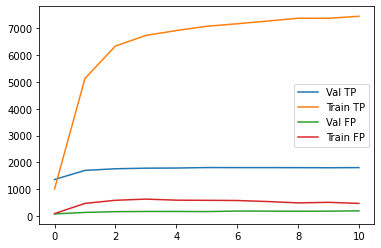

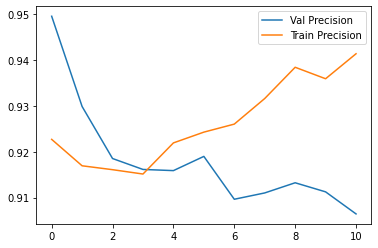

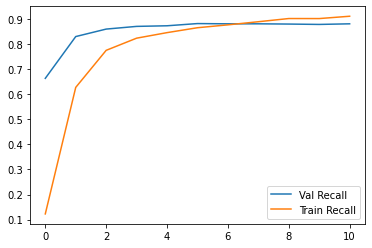

In [ ]:
plt.figure()
plt.plot(history_inc .history['val_auc'], label = 'val_auc')
plt.plot(history_inc .history['auc'], label = 'Train auc')
plt.legend()
plt.show()

plt.figure()
plt.plot(history_inc .history['val_tp'], label = 'Val TP')
plt.plot(history_inc .history['tp'], label = 'Train TP')
plt.plot(history_inc .history['val_fp'], label = 'Val FP')
plt.plot(history_inc .history['fp'], label = 'Train FP')
plt.legend()
plt.show()

plt.figure()
plt.plot(history_inc .history['val_precision'], label = 'Val Precision')
plt.plot(history_inc .history['precision'], label = 'Train Precision')
plt.legend()
plt.show()

plt.figure()
plt.plot(history_inc .history['val_recall'], label = 'Val Recall')
plt.plot(history_inc .history['recall'], label = 'Train Recall')
plt.legend()
plt.show()



In [ ]:
model.save('/content/drive/MyDrive/InceptionV3-299-Epoch50Version4.h5')

128/128 [==============================] - 8s 66ms/step


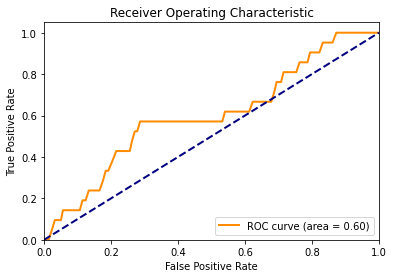

In [ ]:
# Generate predictions for your validation dataset
import numpy as np
y_pred = model.predict(validation_generator)

# # Calculate the ROC curve
# fpr_keras, tpr_keras, thresholds = roc_curve(y_val, y_pred)

# # Calculate the AUC score
# auc_score = auc(fpr_keras, tpr_keras)


from keras.utils import to_categorical
# 将预测结果转换为类别
y_pred_classes = np.argmax(y_pred, axis=1)

# 将标签转换为向量格式
y_true = to_categorical(validation_generator.labels)

# 计算ROC曲线
fpr, tpr, thresholds = roc_curve(y_true[:, 1], y_pred_classes)
roc_auc = auc(fpr, tpr)

# 绘制ROC曲线
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# Generate predictions for your validation dataset
import numpy as np
y_pred = model.predict(validation_generator)



128/128 [==============================] - 11s 84ms/step
